In [ ]:
from google.colab import drive
drive.mount

<function google.colab.drive.mount>

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/datacap')

In [ ]:
pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=428f7e4ad696b77874984bb9b762b16029253338253c8cba9821dbd300ec32be
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


In [ ]:
#from keras.utils import plot_model

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
import pickle
import numpy as np
from nltk.corpus import stopwords
import nltk
import os
import pandas as pd
from attention import AttentionLayer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datacap/cnn_dailymail-3.0.0_train_5000_aug-LM_repeat-2.csv')

In [ ]:
data=data[["article","highlights"]]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
import re

In [ ]:
def clean_text(text,add_eos_sos = False):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-_'()\"#/@;:<>{}`+=~|.!?,]", "", text)
    if add_eos_sos:
      text = '<sos> ' + text + ' <eos>'
    return text

In [ ]:
# nltk라이브러리에서 불용어 리스트를 불러워서 텍스트내의 불용어들을 제거하는 함수 작성
def remove_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    _stopwords.append('cnn') # 불용어 사전에 (cnn)을 추가함. 이는 문서의 의미에 영향을 끼치지 않을 것이기 때문. 괄호지우는 작업도 정규표현식으로 더했더니 cnn만 남아서 그냥 cnn은 다 지워 버리는걸로 결정함
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')  #lemmatize를 위한 단어사전

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def lemmatize_text(data):
    data = nltk.word_tokenize(data)
    lemtzr=WordNetLemmatizer()
    out_data=" "
    for words in data:
        out_data+= lemtzr.lemmatize(words)+" "
    return out_data

In [ ]:
data["article"]=data["article"].apply(clean_text)
data["highlights"]=data["highlights"].apply(clean_text)

In [ ]:
data["article"]=data["article"].apply(remove_stopwords_from_text)
data["highlights"]=data["highlights"].apply(remove_stopwords_from_text)

In [ ]:
data.head(5) #불용어처리 잘된것을 확인

,article,highlights
0,official us president barack obama wants lawma...,syrian official obama climbed top tree know ge...
1,usain bolt rounded world championships sunday ...,usain bolt wins third gold world championship ...
2,kansas city missouri general services administ...,employee agencys kansas city office among hund...
3,los angeles medical doctor vancouver british c...,new canadian doctor says part team examining h...
4,police arrested another teen thursday sixth su...,another arrest made gang rape outside californ...


In [ ]:
# data['article']=data['article'].apply(lambda z: lemmatize_text(z))
# data['highlights']=data['highlights'].apply(lambda z: lemmatize_text(z))
data['article']=data['article'].apply(lemmatize_text)
data['highlights']=data['highlights'].apply(lemmatize_text)

In [ ]:
data.head(5) #레마타이즈 잘된것을 확인

,article,highlights
0,official u president barack obama want lawmak...,syrian official obama climbed top tree know g...
1,usain bolt rounded world championship sunday ...,usain bolt win third gold world championship ...
2,kansa city missouri general service administr...,employee agency kansa city office among hundr...
3,los angeles medical doctor vancouver british ...,new canadian doctor say part team examining h...
4,police arrested another teen thursday sixth s...,another arrest made gang rape outside califor...


In [ ]:
data.highlights=data.highlights.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
data.article=data.article.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

In [ ]:
data.head(5) # 한 글자짜리 단어들이 다 사라진 것을 확인

,article,highlights
0,official president barack obama want lawmaker ...,syrian official obama climbed top tree know ge...
1,usain bolt rounded world championship sunday c...,usain bolt win third gold world championship a...
2,kansa city missouri general service administra...,employee agency kansa city office among hundre...
3,los angeles medical doctor vancouver british c...,new canadian doctor say part team examining ha...
4,police arrested another teen thursday sixth su...,another arrest made gang rape outside californ...


In [ ]:
# start_token = 'sostok'
# end_token = 'eostok' '<sos> ' + text + ' <eos>'

# data['decoder_input'] = data['highlights'].apply(lambda x : 'sostoken '+ x)
# data['decoder_target'] = data['highlights'].apply(lambda x : x + ' eostoken')

In [ ]:
start_token = '<sos>'
end_token = '<eos>'

data["highlights"]=data["highlights"].apply(lambda x: '<sos>'+x+'<eos>')

In [ ]:
data.head(5)

,article,highlights
0,official president barack obama want lawmaker ...,<sos>syrian official obama climbed top tree kn...
1,usain bolt rounded world championship sunday c...,<sos>usain bolt win third gold world champions...
2,kansa city missouri general service administra...,<sos>employee agency kansa city office among h...
3,los angeles medical doctor vancouver british c...,<sos>new canadian doctor say part team examini...
4,police arrested another teen thursday sixth su...,<sos>another arrest made gang rape outside cal...


In [ ]:
def text_tokenize(text):
  tokens = []
  for line in text:
    tokens.append(text_to_word_sequence(line, lower=True, split=' '))
  return tokens

In [ ]:
input_tokens  = text_tokenize(data["article"])
output_tokens  = text_tokenize(data["highlights"])

In [ ]:
print(data["article"][0])
print(input_tokens[0])
print('\n\n',data["highlights"][0])
print(output_tokens[0])

official president barack obama want lawmaker weigh whether use military force syria obama sent letter head house senate saturday night hour announcing belief military action syrian target right step take alleged use chemical weapon proposed legislation obama asks congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction step set turn international crisis fierce domestic political battle key question looming debate un weapon inspector find syria happens congress vote syrian government react televised address white house rose garden earlier saturday president said would take case congress want believe authority carry military action without specific congressional authorization know country stronger take course action even effective said debate issue big business usual obama said top congressional leader agreed schedule debate body return washington september senate foreign relation committee hold hearing matter tuesday 

# 새 섹션

In [ ]:
VOCAB_SIZE=64000

In [ ]:
max_input_len = 850
max_output_len = 42

In [ ]:
def vocab_creater(text_lists, VOCAB_SIZE):
  tokenizer = Tokenizer(num_words=VOCAB_SIZE)
  tokenizer.fit_on_texts(text_lists)
  dictionary = tokenizer.word_index
  word2idx = {}
  idx2word = {}
  for k, v in dictionary.items():
      if v < VOCAB_SIZE:
          word2idx[k] = v-1
          idx2word[v-1] = k
      if v >= VOCAB_SIZE:
          break
  return word2idx, idx2word

In [ ]:
#### create word_index and dump
 
word2idx, idx2word = vocab_creater(data['article']+data['highlights'],VOCAB_SIZE)
word_index = {}
word_index['word2idx'] = word2idx
word_index['idx2word'] = idx2word
pickle.dump(word_index, open('word_idx.pkl','wb'))

In [ ]:
#load word_index

word_index = pickle.load(open('word_idx.pkl','rb'))
print(word_index.keys())
idx2word = word_index['idx2word']
word2idx = word_index['word2idx']
del word_index
print(word2idx)
print(idx2word)

dict_keys(['word2idx', 'idx2word'])
{'said': 0, 'say': 1, 'one': 2, 'people': 3, 'year': 4, 'would': 5, 'new': 6, 'time': 7, 'state': 8, 'also': 9, 'two': 10, 'eos': 11, 'sos': 12, 'could': 13, 'first': 14, 'day': 15, 'like': 16, 'told': 17, 'world': 18, 'president': 19, 'last': 20, 'government': 21, 'country': 22, 'official': 23, 'get': 24, 'many': 25, 'according': 26, 'police': 27, 'group': 28, 'report': 29, 'make': 30, 'family': 31, 'right': 32, 'american': 33, 'week': 34, 'home': 35, 'way': 36, 'three': 37, 'united': 38, 'life': 39, 'may': 40, 'take': 41, 'woman': 42, 'city': 43, 'even': 44, 'million': 45, 'back': 46, 'obama': 47, 'month': 48, 'work': 49, 'made': 50, 'child': 51, 'know': 52, 'since': 53, 'still': 54, 'show': 55, 'want': 56, 'think': 57, 'another': 58, 'see': 59, 'go': 60, 'case': 61, 'house': 62, 'part': 63, 'come': 64, 'court': 65, 'going': 66, 'attack': 67, 'need': 68, 'much': 69, 'around': 70, 'security': 71, 'well': 72, 'military': 73, 'national': 74, 'help': 7

In [ ]:
GLOVE_PATH = '/content/drive/MyDrive/Colab Notebooks/datacap/glove/glove.42B.300d.txt'
GLOVE_VECTOR_LENGHT = 300

In [ ]:
def read_glove_vectors(path, lenght):
    embeddings = {}
    with open(path) as glove_f:
        for line in glove_f:
            chunks = line.split()
            assert len(chunks) == lenght + 1
            embeddings[chunks[0]] = np.array(chunks[1:], dtype='float32')
    return embeddings

In [ ]:
GLOVE_INDEX = read_glove_vectors(GLOVE_PATH, GLOVE_VECTOR_LENGHT)
## dump GLOVE_INDEX
pickle.dump(GLOVE_INDEX, open('/content/drive/My Drive/Colab Notebooks/GLOVE_INDEX.pkl','wb'))

In [ ]:
#load glove_index
#GLOVE_INDEX = pickle.load(open('/content/drive/My Drive/Colab Notebooks/GLOVE_INDEX.pkl','rb'))

In [ ]:
def embedding_matrix_creater(word_index,embedding_dimention = 300):
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
  for i, word in word_index.items():
      embedding_vector = GLOVE_INDEX.get(word)#그 단어에 대한 글로브 벡터를 찾아와서 연결
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector # 벡터를 임베딩에 넘겨줌
  return embedding_matrix #임베딩 메트릭스를 반환

In [ ]:
embedding_matrix = embedding_matrix_creater(idx2word)
pickle.dump(embedding_matrix,open('embedding_matrix.pkl','wb'))

#embedding_matrix = pickle.load(open('embedding_matrix.pkl','rb'))

In [ ]:
def token2seq(text):
  seq = []
  for line in text:
    temp = []
    for word in line:
      if word in word2idx.keys():
        temp.append(word2idx[word])
    seq.append(temp)
  return seq

In [ ]:
input_seq = token2seq(input_tokens)
output_seq = token2seq(output_tokens)

In [ ]:
print(input_seq[:5])
print(output_seq[:5])

[[23, 19, 780, 47, 56, 1271, 4994, 175, 109, 73, 86, 225, 47, 593, 875, 200, 62, 374, 211, 188, 171, 4065, 699, 73, 227, 427, 817, 32, 424, 41, 835, 109, 1150, 448, 1796, 1654, 47, 2903, 390, 3982, 109, 73, 86, 9129, 8750, 1001, 15615, 694, 343, 1473, 1150, 448, 448, 1074, 2929, 424, 118, 524, 95, 611, 3908, 1120, 121, 740, 489, 190, 9667, 914, 519, 448, 1996, 180, 225, 1856, 390, 280, 427, 21, 4164, 5086, 772, 176, 62, 1936, 2764, 298, 211, 19, 0, 5, 41, 61, 390, 56, 261, 83, 1209, 73, 227, 141, 1493, 1401, 5229, 52, 22, 2656, 41, 449, 227, 44, 1747, 0, 914, 96, 207, 204, 3503, 47, 0, 168, 1401, 89, 965, 2698, 914, 221, 405, 194, 630, 374, 325, 1118, 459, 599, 763, 417, 98, 854, 805, 9489, 0, 1988, 318, 707, 421, 1586, 427, 611, 689, 664, 519, 1996, 562, 225, 707, 1586, 151, 1750, 519, 1996, 148, 225, 1300, 397, 1716, 175, 1150, 448, 107, 67, 201, 20, 34, 3088, 3142, 2049, 92, 3366, 336, 21711, 175, 1150, 448, 107, 519, 235, 924, 33898, 17, 437, 211, 107, 448, 128, 4364, 869, 67, 3088

In [ ]:

## padding
input_seq = pad_sequences(input_seq, maxlen = max_input_len, dtype='int32', padding='post', truncating='post')
output_seq = pad_sequences(output_seq, maxlen = max_output_len, dtype='int32', padding='post', truncating='post')

# 새 섹션

In [ ]:
#from tensorflow.keras.layers import CuDNNLSTM

In [ ]:
 
# from keras.utils import plot_model

In [ ]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional,Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


In [ ]:
def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

In [ ]:
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [ ]:
# embedding_dim = 32
# hidden_size = 128

# # 인코더
# encoder_inputs = Input(shape=(max_article_len,)) #인코더 입력의 형태를 지정

# # 인코더의 임베딩 층
# enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) #토크나이징한 데이터를 벡터공간으로 맵핑

# #return_sequence:각 시퀀스마다 출력을 반환할지 여부를 결정,순환신경망 층을 쌓기위해 전체시퀀스를 출력해주어야 할때 사용.
# #return_state : 마지박 상태 값의 반환 여부
# #recurrent_initializer : 초기값을 무엇으로 할 것인지 선언
# #dropout : 0.4의 노드들이 랜덤하게 훈련
# #recurrent_dropout: 순환 드롭아웃을 적용,동일한 드롭아웃 마스크를 모든 타임스텝에 적용함, 드롭아웃시 수렴하는것이 늦어지므로 에포크수를 늘린다.

# # 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4,name='enc_lstm1') 
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# # 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4,name='enc_lstm2')
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) # 이전 LSTM셀의 ouput1을 입력으로 받음

# # 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,name='enc_lstm3')
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
from keras import backend as K 
K.clear_session() 

EMBEDDING_DIM = 300
hidden_size = 128

# Encoder 
encoder_inputs = Input(shape=(max_input_len,))  ### input (none,max_input_len)

## embedding
enc_emb_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, 
                      input_length = max_input_len, weights = [embedding_matrix],trainable = False)

enc_emb = enc_emb_layer(encoder_inputs)




# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4,name='enc_lstm1') 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4,name='enc_lstm2')
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) # 이전 LSTM셀의 ouput1을 입력으로 받음

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,name='enc_lstm3')
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder. 
decoder_inputs = Input(shape=(None,))  ## input(None,)

### embedding

dec_emb_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, 
                      input_length = max_output_len, weights = [embedding_matrix],trainable = False)


dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm =  LSTM(hidden_size, return_sequences=True, return_state=True ,dropout=0.4,recurrent_dropout = 0.4,name='dec_lstm')
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
decoder_dense_outputs = decoder_dense(decoder_concat_input) 





model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_dense_outputs,name='glove_seq2attn')

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy',metrics=['accuracy',recall,precision,f1score])
#,metrics=[keras.metrics.Precision(), keras.metrics.Recall()]) 
#model.load_weights('/content/drive/MyDrive/Colab Notebooks/datacap/glove/model_weights.h5')
model.summary()

Model: "glove_seq2attn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 850)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 850, 300)     19200000    input_1[0][0]                    
__________________________________________________________________________________________________
enc_lstm1 (LSTM)                [(None, 850, 128), ( 219648      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_____________________________________________________________________________________

In [ ]:
## load history

if os.path.exists('history2.pkl'):
  history = pickle.load(open('history2.pkl','rb'))
else:
  history = {}
  history['loss'] = []
  history['val_loss'] = []
  #pickle.dump(history2,open('history2.pkl','wb'))

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
  def on_train_begin(self,logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
 
  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
    val_targ = self.model.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    _val_recall = recall_score(val_targ, val_predict)
    _val_precision = precision_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
    return
 
metrics = Metrics()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3) # verbose=1 :언제 멈추었는지 화면에 출력 , patience : 성능이 증가하지 않는 epoch를 몇번이나 반복할 것인가 baseline=0.4 :특정값 도달시 더 돌리지 않음
mc = ModelCheckpoint('best_glov_model.h5', monitor='val_loss', mode='min', save_best_only=True ) # 가장 좋은 모델을 저장하기 위함 # monitor='val_loss', mode='min', save_best_only=True

In [ ]:
#train model
epoch_history = model.fit([input_seq,output_seq[:,:-1]], output_seq.reshape(output_seq.shape[0],output_seq.shape[1], 1)[:,1:] ,
                      epochs=5,batch_size=128,validation_split = 0.05,callbacks=[es,mc])
  
  ### save model weight on every epochs
model.save_weights('model_weights_glove.h5')   

# if val_loss_prev > epoch_history.history['val_loss'][-1]:
#   model.save_weights('best_model_weight2.h5')
#   val_loss_prev = epoch_history.history['val_loss'][-1]

# history['loss'].append(epoch_history.history['loss'])
# history['val_loss'].append(epoch_history.history['val_loss'])

#save model history
pickle.dump(history,open('history2.pkl','wb'))

Epoch 1/5
75/75 [==============================] - 560s 7s/step - loss: 6.6148 - accuracy: 0.3039 - recall: 9.4515e-05 - precision: 2.2446e-04 - f1score: 1.3282e-04 - val_loss: 5.9208 - val_accuracy: 0.3455 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/5
75/75 [==============================] - 546s 7s/step - loss: 5.8411 - accuracy: 0.3311 - recall: 6.1456e-05 - precision: 1.4607e-04 - f1score: 8.6447e-05 - val_loss: 5.6480 - val_accuracy: 0.3451 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/5
75/75 [==============================] - 546s 7s/step - loss: 5.6303 - accuracy: 0.3331 - recall: 3.6392e-05 - precision: 8.4683e-05 - f1score: 5.0840e-05 - val_loss: 5.4811 - val_accuracy: 0.3503 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 4/5
75/75 [==============================] - 550s 7s/step - loss: 5.4637 - accuracy: 0.3352 - recall: 1.2656e-04 - precision: 2.9978e-04

In [ ]:
import matplotlib.pyplot as plt


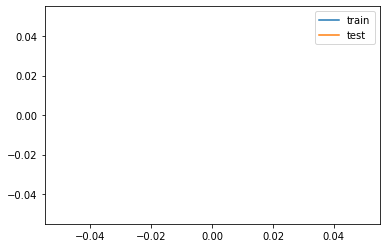

In [ ]:
plt.plot(history['loss'], label='train') 
plt.plot(history['val_loss'], label='test') 
plt.legend()
plt.show()

# 새 섹션

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])




# decoder inference


decoder_state_input_h = Input(shape=(600,))
decoder_state_input_c = Input(shape=(600,))
decoder_hidden_state_input = Input(shape=(max_input_len,600))


dec_emb2= dec_emb_layer(decoder_inputs)


decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])


decoder_outputs2 = decoder_dense(decoder_inf_concat)




# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],[decoder_outputs2] + [state_h2, state_c2])

ValueError: ignored

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = word2idx['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = idx2word[sampled_token_index]

        if(sampled_token!='sos'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eos' or len(decoded_sentence.split()) >= (max_input_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=word2idx['sos']) and i!=word2idx['eos']):
        newString=newString+idx2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+idx2word[i]+' '
    return newString

In [ ]:
for i in range(0,10):
  print("Text : ",seq2text(input_seq[i]))
  print("Original summary :",seq2summary(output_seq[i]))
  print("Predicted summary :",decode_sequence(input_seq[i].reshape(1,max_input_len)),'\n\n')

In [ ]:
def predict_summary():
  text = input('enter text')
  print('input text:',text)
  clean_text_ = clean_text(text)
  text_input_tokens = text_to_word_sequence(clean_text_, lower=True, split=' ')
  input__seq = []
  for word in text_input_tokens:
    if word in word2idx.keys():
      input__seq.append(word2idx[word])
  input__seq = pad_sequences([input__seq], maxlen = max_input_len, dtype='int32', padding='post', truncating='post')
  print("Predicted summary:",decode_sequence(input__seq.reshape(1,max_input_len)))

In [ ]:
predict_summary()
